### Importing Libraries

In [76]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import os
import joblib

import warnings
warnings.filterwarnings("ignore")

### Loading Dataset

In [77]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("neurocipher/indian-flight-dataser")

print("Dataset downloaded successfully.")
print("Path to dataset files:", path)

Dataset downloaded successfully.
Path to dataset files: C:\Users\Casper\.cache\kagglehub\datasets\neurocipher\indian-flight-dataser\versions\1


In [78]:
flight_data = pd.read_csv(path + "/IndianFlightdata - Sheet1.csv")
print('Flight data loaded successfully.')

Flight data loaded successfully.


### EDA

In [79]:
flight_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [80]:
print('Columns:', flight_data.columns.tolist())

Columns: ['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price']


In [81]:
flight_data.shape

(10683, 11)

In [82]:
flight_data.columns = [col.lower() for col in flight_data.columns]

In [83]:
flight_data['date_of_journey'] = pd.to_datetime(flight_data['date_of_journey'], format='%d/%m/%Y')

In [84]:
flight_data['day'] = flight_data['date_of_journey'].dt.day
flight_data['month'] = flight_data['date_of_journey'].dt.month
flight_data['year'] = flight_data['date_of_journey'].dt.year
flight_data['weekday'] = flight_data['date_of_journey'].dt.weekday

In [85]:
flight_data['day'] = flight_data['day'].astype('int8')
flight_data['month'] = flight_data['month'].astype('int8')
flight_data['year'] = flight_data['year'].astype('int16')
flight_data['weekday'] = flight_data['weekday'].astype('int8')

In [86]:
flight_data['day_sin'] = np.sin(2 * np.pi * flight_data['day'] / 31)
flight_data['day_cos'] = np.cos(2 * np.pi * flight_data['day'] / 31)

flight_data['weekday_sin'] = np.sin(2 * np.pi * flight_data['weekday'] / 7)
flight_data['weekday_cos'] = np.cos(2 * np.pi * flight_data['weekday'] / 7)

flight_data['month_sin'] = np.sin(2 * np.pi * flight_data['month'] / 12)
flight_data['month_cos'] = np.cos(2 * np.pi * flight_data['month'] / 12)    

In [87]:
flight_data['total_stops'] = flight_data['total_stops'].str.extract(r'(\d+)').fillna(0).astype(int).astype('int8')

In [88]:
flight_data.drop(columns=['dep_time', 'arrival_time'], inplace=True)

In [89]:
import re

def convert_duration_to_minutes(duration_str):
    """Convert duration string like '2h 50m' to total minutes"""
    hours = re.search(r'(\d+)h', str(duration_str))
    minutes = re.search(r'(\d+)m', str(duration_str))
    
    h = int(hours.group(1)) if hours else 0
    m = int(minutes.group(1)) if minutes else 0
    
    return h * 60 + m

flight_data['duration'] = flight_data['duration'].apply(convert_duration_to_minutes)

In [90]:
# Keep only top 3 values in additional_info, rest as 'other'
top_3_info = flight_data['additional_info'].value_counts().head(3).index
flight_data['additional_info'] = flight_data['additional_info'].apply(
    lambda x: x if x in top_3_info else 'other'
)

In [91]:
top_6_airline = flight_data['airline'].value_counts().head(6).index
flight_data['airline'] = flight_data['airline'].apply(
    lambda x: x if x in top_6_airline else 'other'
)

In [92]:
top_12_route = flight_data['route'].value_counts().head(12).index
flight_data['route'] = flight_data['route'].apply(
    lambda x: x if x in top_12_route else 'other'
)

In [93]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          10683 non-null  object        
 1   date_of_journey  10683 non-null  datetime64[ns]
 2   source           10683 non-null  object        
 3   destination      10683 non-null  object        
 4   route            10683 non-null  object        
 5   duration         10683 non-null  int64         
 6   total_stops      10683 non-null  int8          
 7   additional_info  10683 non-null  object        
 8   price            10683 non-null  int64         
 9   day              10683 non-null  int8          
 10  month            10683 non-null  int8          
 11  year             10683 non-null  int16         
 12  weekday          10683 non-null  int8          
 13  day_sin          10683 non-null  float64       
 14  day_cos          10683 non-null  float

In [94]:
num_cols = flight_data.select_dtypes(include=['int64', 'float64','int8','int16']).columns.tolist()
cat_cols = flight_data.select_dtypes(include=['object']).columns.tolist()

flight_data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,10683.0,643.093232,507.862001,5.000000e+00,1.700000e+02,520.000000,9.300000e+02,2.860000e+03
total_stops,10683.0,0.824113,0.675244,0.000000e+00,0.000000e+00,1.000000,1.000000e+00,4.000000e+00
price,10683.0,9087.064121,4611.359167,1.759000e+03,5.277000e+03,8372.000000,1.237300e+04,7.951200e+04
day,10683.0,13.508378,8.479277,1.000000e+00,6.000000e+00,12.000000,2.100000e+01,2.700000e+01
month,10683.0,4.708602,1.164357,3.000000e+00,3.000000e+00,5.000000,6.000000e+00,6.000000e+00
year,10683.0,2019.000000,0.000000,2.019000e+03,2.019000e+03,2019.000000,2.019000e+03,2.019000e+03
weekday,10683.0,2.934850,2.006698,0.000000e+00,1.000000e+00,3.000000,5.000000e+00,6.000000e+00
day_sin,10683.0,0.068573,0.740000,-9.884683e-01,-7.247928e-01,0.201299,9.377521e-01,9.680771e-01
day_cos,10683.0,-0.013111,0.669044,-9.948693e-01,-7.587581e-01,0.151428,6.889669e-01,9.795299e-01
weekday_sin,10683.0,0.030536,0.717659,-9.749279e-01,-7.818315e-01,0.000000,7.818315e-01,9.749279e-01


In [95]:
### Creating Season Column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

flight_data['season'] = flight_data['month'].apply(get_season)

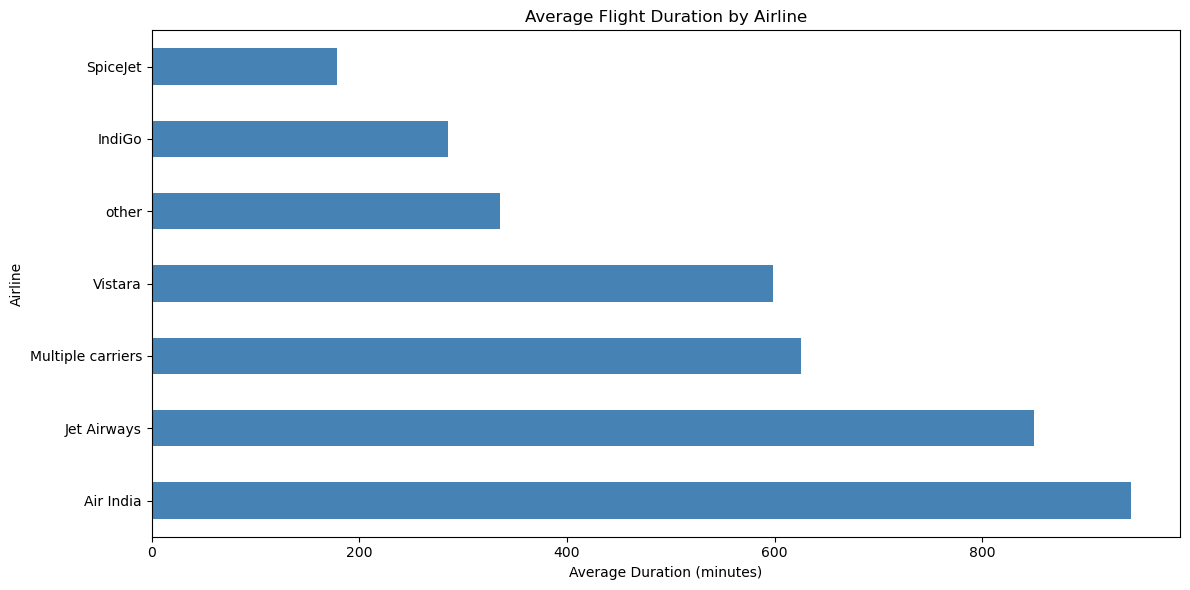

In [96]:
### 1. Average Flight Duration by Airline
avg_duration_by_airline = flight_data.groupby('airline')['duration'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_duration_by_airline.plot(kind='barh', color='steelblue')
plt.xlabel('Average Duration (minutes)')
plt.ylabel('Airline')
plt.title('Average Flight Duration by Airline')
plt.tight_layout()
plt.show()

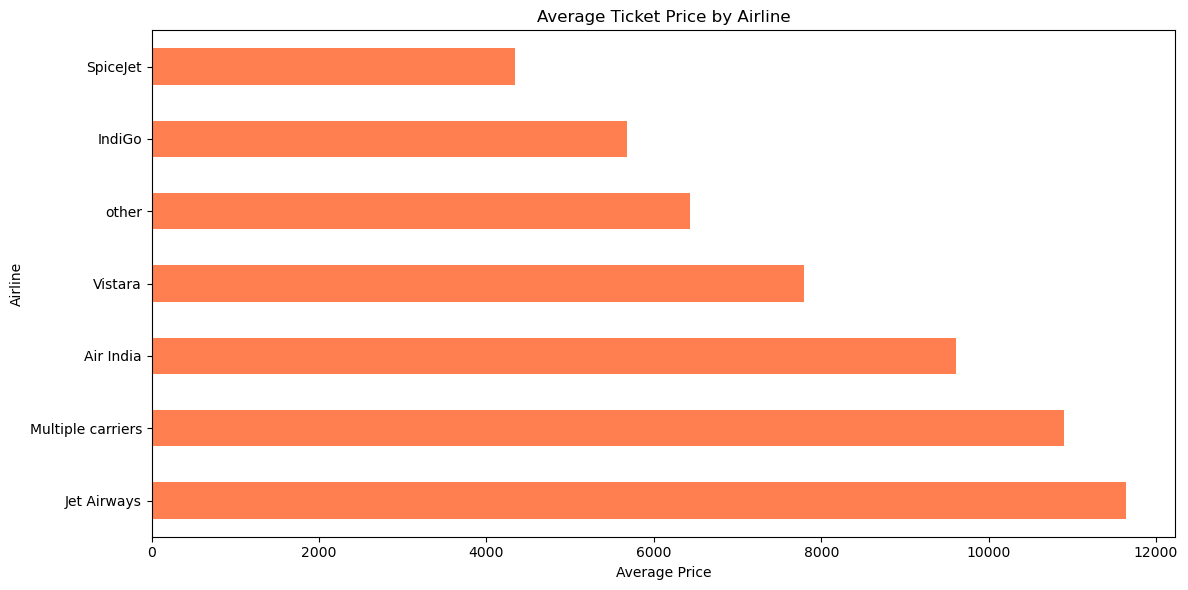

In [97]:
# 2. Average Ticket Price by Airline
avg_price_by_airline = flight_data.groupby('airline')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_price_by_airline.plot(kind='barh', color='coral')
plt.xlabel('Average Price')
plt.ylabel('Airline')
plt.title('Average Ticket Price by Airline')
plt.tight_layout()
plt.show()

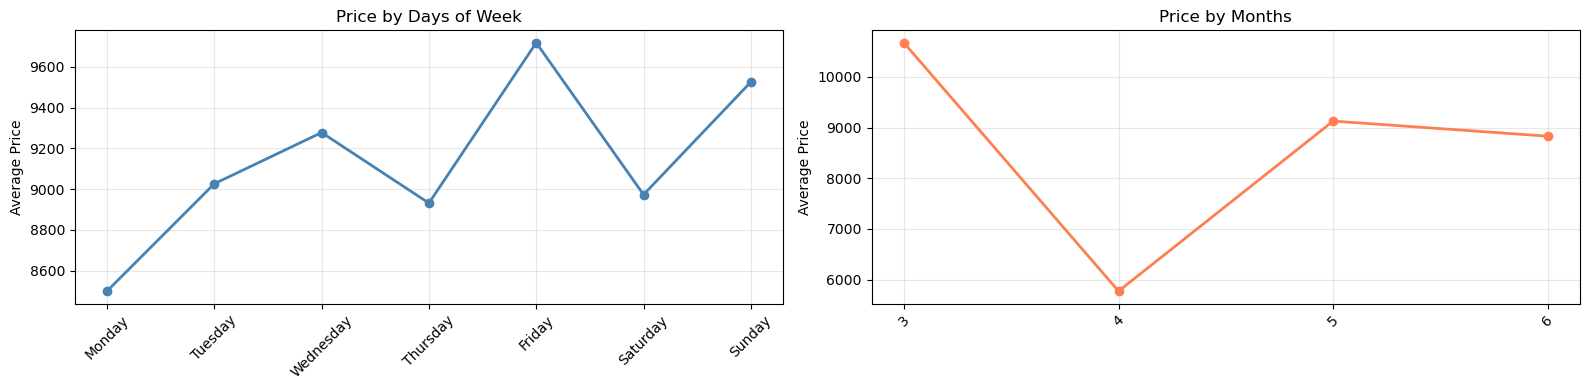

In [98]:
# 3. Average Ticket Price by Days of Week and Months
weekdays_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
flight_data['weekday_name'] = flight_data['weekday'].map(weekdays_map)

# According to the days of week
avg_price_by_weekday = flight_data.groupby('weekday_name')['price'].mean()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_price_by_weekday = avg_price_by_weekday.reindex(weekday_order)

# According to the months
avg_price_by_month = flight_data.groupby('month')['price'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Days of week
axes[0].plot(range(len(avg_price_by_weekday)), avg_price_by_weekday.values, marker='o', color='steelblue', linewidth=2)
axes[0].set_xticks(range(len(avg_price_by_weekday)))
axes[0].set_xticklabels(avg_price_by_weekday.index, rotation=45)
axes[0].set_ylabel('Average Price')
axes[0].set_title('Price by Days of Week')
axes[0].grid(alpha=0.3)

# Months
axes[1].plot(range(len(avg_price_by_month)), avg_price_by_month.values, marker='o', color='coral', linewidth=2)
axes[1].set_xticks(range(len(avg_price_by_month)))
axes[1].set_xticklabels(avg_price_by_month.index, rotation=45)
axes[1].set_ylabel('Average Price')
axes[1].set_title('Price by Months')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

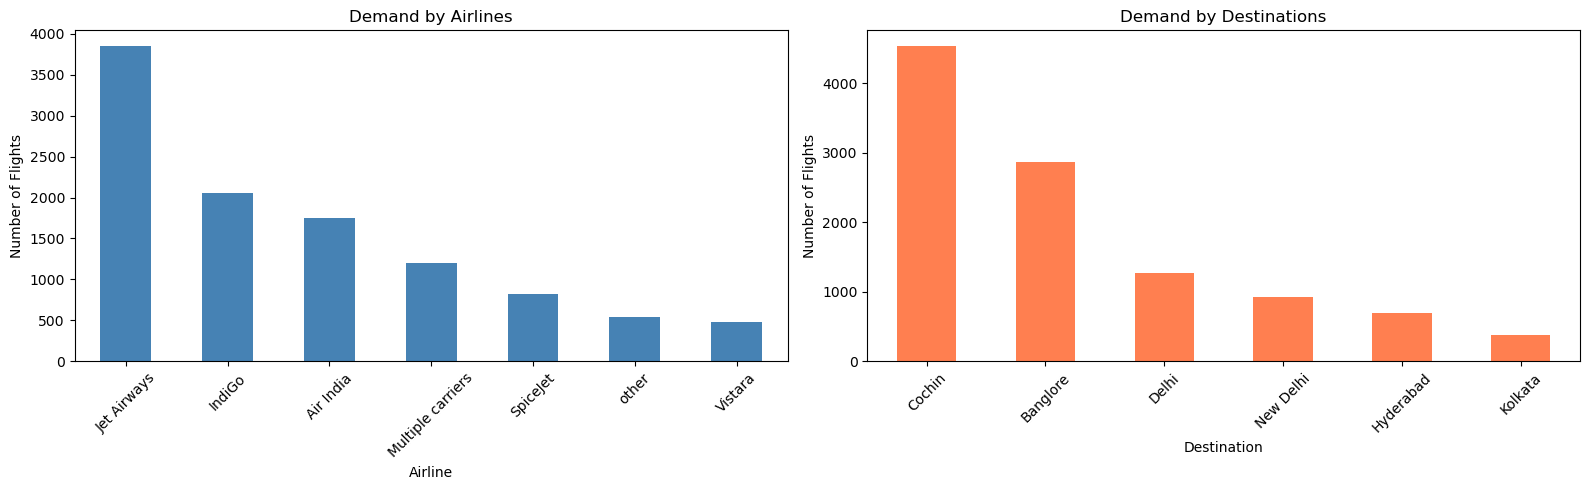

In [99]:
# 4. Demand by Airlines and Destinations

# Demand by airlines
airline_demand = flight_data['airline'].value_counts()

# Demand by destinations
destination_demand = flight_data['destination'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Airline demand
airline_demand.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Demand by Airlines')
axes[0].set_ylabel('Number of Flights')
axes[0].set_xlabel('Airline')
axes[0].tick_params(axis='x', rotation=45)

# Destination demand
destination_demand.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Demand by Destinations')
axes[1].set_ylabel('Number of Flights')
axes[1].set_xlabel('Destination')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

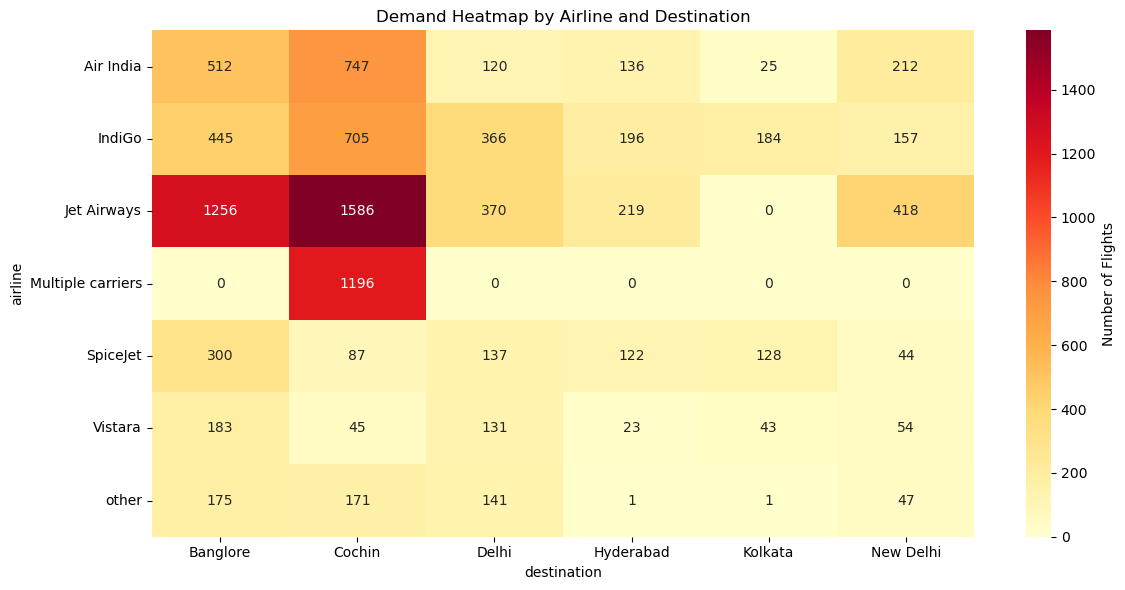

In [100]:
# Heatmap: Airline vs Destination Demand
airline_destination = pd.crosstab(flight_data['airline'], flight_data['destination'])
plt.figure(figsize=(12, 6))
sns.heatmap(airline_destination, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Number of Flights'})
plt.title('Demand Heatmap by Airline and Destination')
plt.tight_layout()
plt.show()

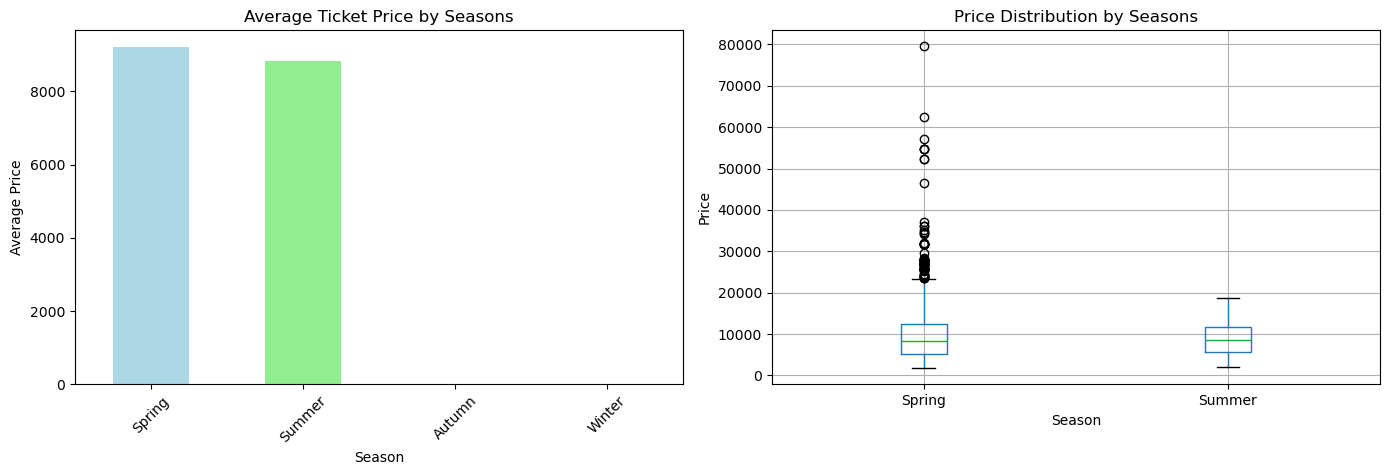

In [101]:
# 5. Average Ticket Price Analysis by Seasons
avg_price_by_season = flight_data.groupby('season')['price'].agg(['mean', 'median', 'std', 'count'])

# Season order
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_prices = flight_data.groupby('season')['price'].mean().reindex(season_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
season_prices.plot(kind='bar', ax=axes[0], color=['lightblue', 'lightgreen', 'yellow', 'orange'])
axes[0].set_title('Average Ticket Price by Seasons')
axes[0].set_ylabel('Average Price')
axes[0].set_xlabel('Season')
axes[0].tick_params(axis='x', rotation=45)

# Box plot
flight_data.boxplot(column='price', by='season', ax=axes[1])
axes[1].set_title('Price Distribution by Seasons')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Season')
plt.suptitle('')

plt.tight_layout()
plt.show()

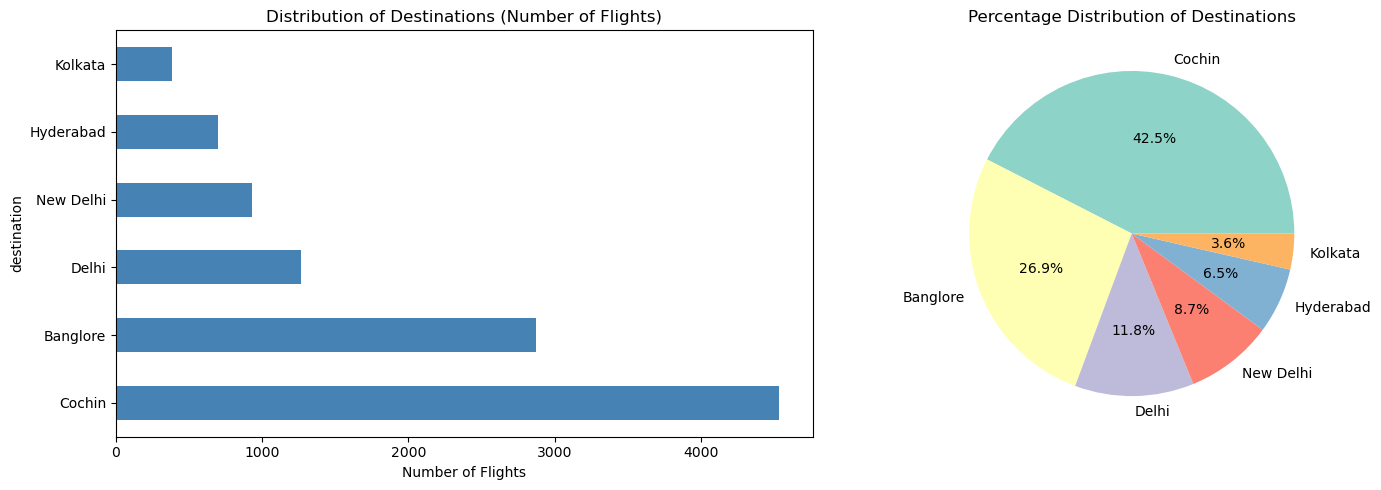

In [102]:
## 6. Distribution of Destinations
# Distribution of destinations
destination_distribution = flight_data['destination'].value_counts()

# Percentage distribution
destination_percent = (flight_data['destination'].value_counts() / len(flight_data) * 100)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
destination_distribution.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Destinations (Number of Flights)')
axes[0].set_xlabel('Number of Flights')

# Pie chart
colors = plt.cm.Set3(range(len(destination_distribution)))
axes[1].pie(destination_distribution.values, labels=destination_distribution.index, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Percentage Distribution of Destinations')

plt.tight_layout()
plt.show()

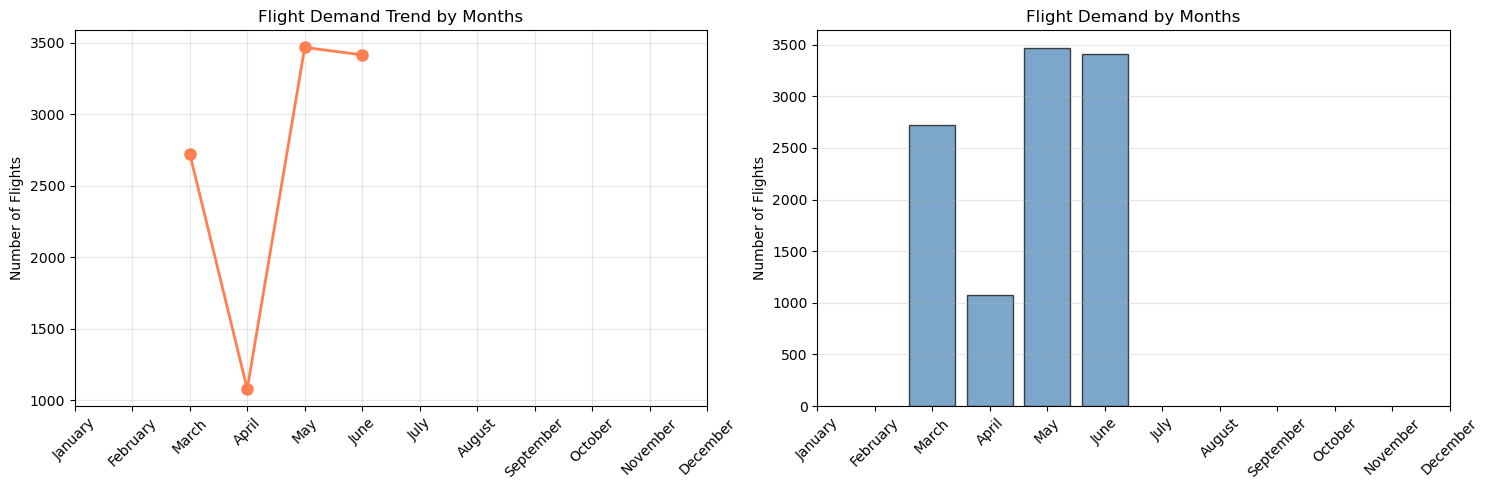

In [103]:
# Demand analysis by months
demand_by_month = flight_data['month'].value_counts().sort_index()
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
            'July', 'August', 'September', 'October', 'November', 'December']

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Line plot
axes[0].plot(demand_by_month.index, demand_by_month.values, marker='o', linewidth=2, 
            markersize=8, color='coral')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels([month_names[i-1] for i in range(1, 13)], rotation=45)
axes[0].set_title('Flight Demand Trend by Months')
axes[0].set_ylabel('Number of Flights')
axes[0].grid(alpha=0.3)

# Bar plot
axes[1].bar(demand_by_month.index, demand_by_month.values, color='steelblue', 
            edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels([month_names[i-1] for i in range(1, 13)], rotation=45)
axes[1].set_title('Flight Demand by Months')
axes[1].set_ylabel('Number of Flights')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

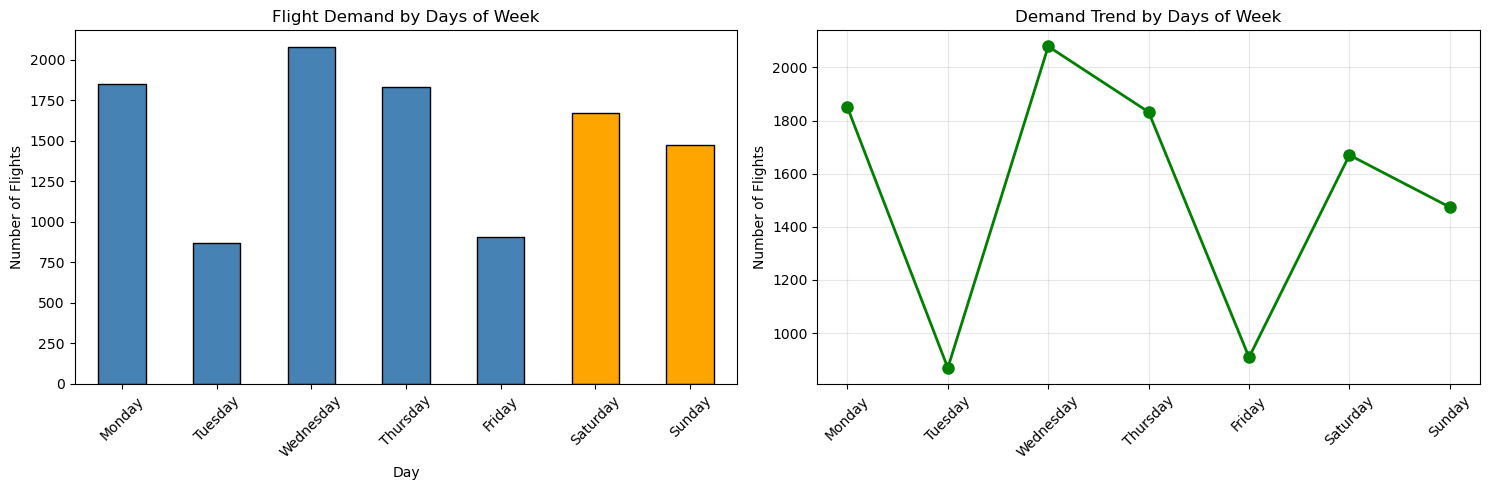

In [104]:
# Demand analysis by days of week
demand_by_weekday = flight_data['weekday_name'].value_counts()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_by_weekday = demand_by_weekday.reindex(weekday_order)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
colors_weekday = ['steelblue']*5 + ['orange']*2  # Different color for weekends
demand_by_weekday.plot(kind='bar', ax=axes[0], color=colors_weekday, edgecolor='black')
axes[0].set_title('Flight Demand by Days of Week')
axes[0].set_ylabel('Number of Flights')
axes[0].set_xlabel('Day')
axes[0].set_xticklabels(weekday_order, rotation=45)

# Line plot
axes[1].plot(range(len(demand_by_weekday)), demand_by_weekday.values, marker='o', 
            linewidth=2, markersize=8, color='green')
axes[1].set_xticks(range(len(demand_by_weekday)))
axes[1].set_xticklabels(weekday_order, rotation=45)
axes[1].set_title('Demand Trend by Days of Week')
axes[1].set_ylabel('Number of Flights')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

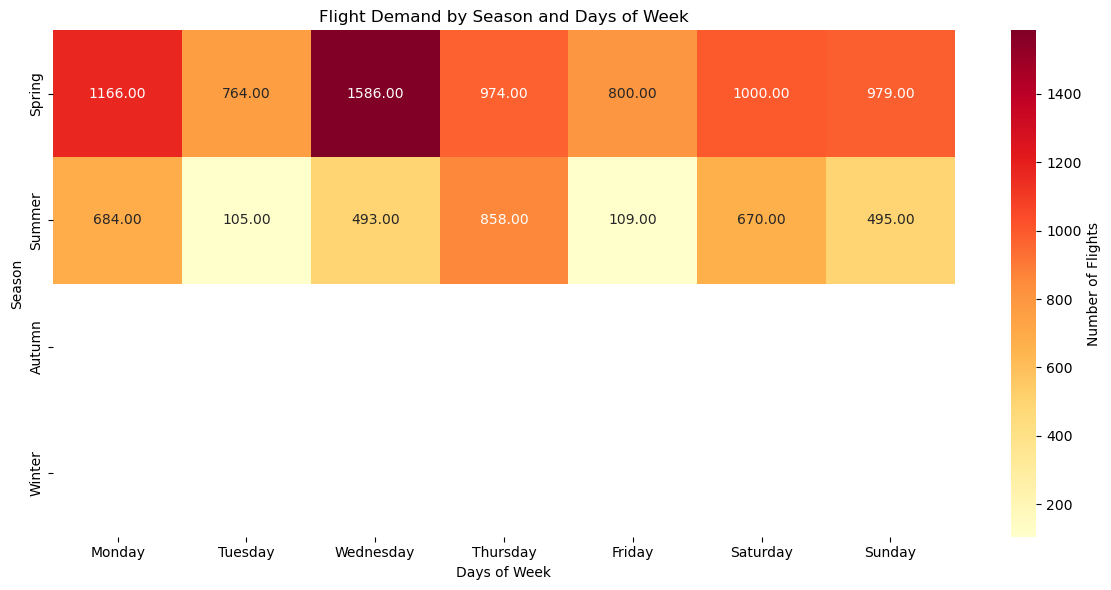

In [105]:
# Combined Analysis: Seasons and Days of Week
demand_season_weekday = pd.crosstab(flight_data['season'], flight_data['weekday_name'])
demand_season_weekday = demand_season_weekday[weekday_order]  # Sort
demand_season_weekday = demand_season_weekday.reindex(season_order)

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(demand_season_weekday, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Number of Flights'})
plt.title('Flight Demand by Season and Days of Week')
plt.xlabel('Days of Week')
plt.ylabel('Season')
plt.tight_layout()
plt.show()

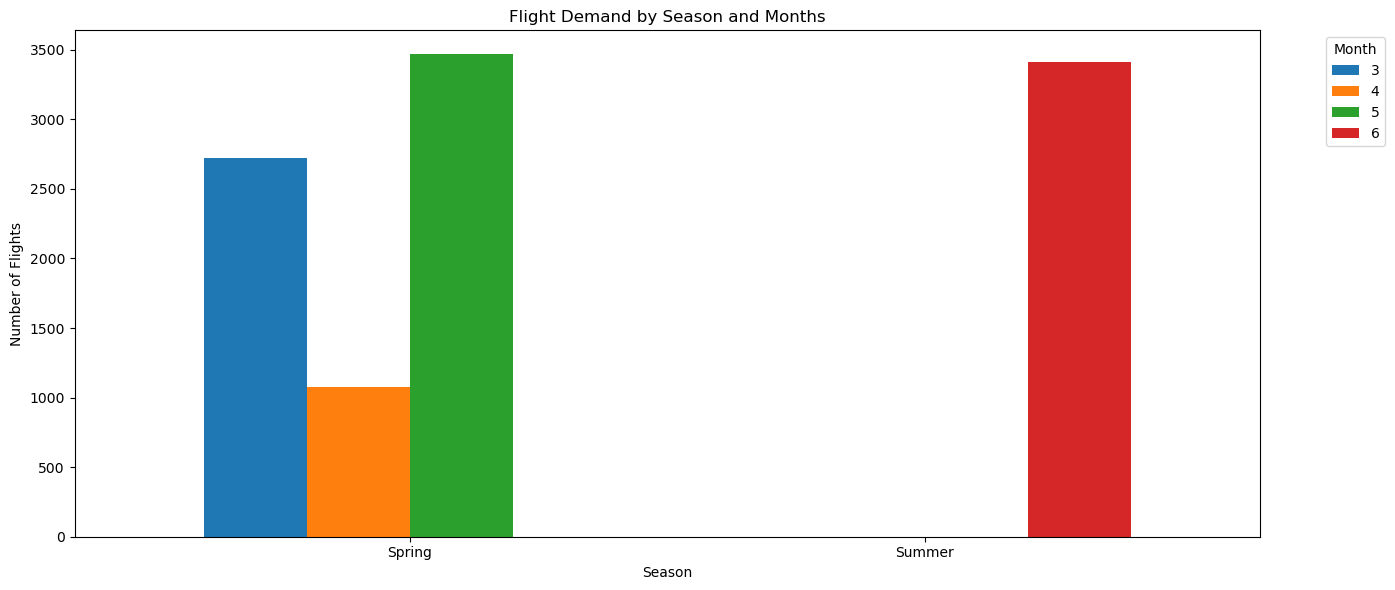

In [106]:
# Combined Analysis: Seasons and Months
demand_season_month = pd.crosstab(flight_data['season'], flight_data['month'])

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))
demand_season_month.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Flight Demand by Season and Months')
ax.set_ylabel('Number of Flights')
ax.set_xlabel('Season')
ax.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

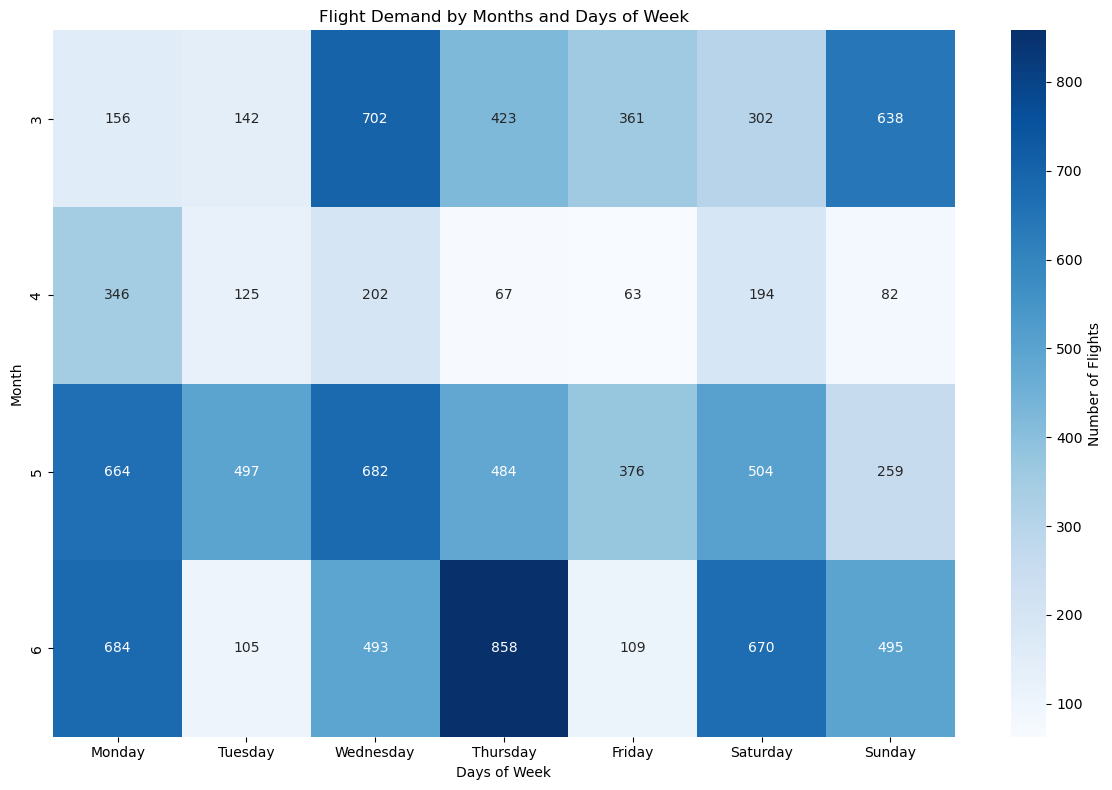

In [107]:
# Combined Analysis: Months and Days of Week
demand_month_weekday = pd.crosstab(flight_data['month'], flight_data['weekday_name'])
demand_month_weekday = demand_month_weekday[weekday_order]

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(demand_month_weekday, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Flights'})
plt.title('Flight Demand by Months and Days of Week')
plt.xlabel('Days of Week')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

### Data Preprocessing

In [108]:
X = flight_data[['airline', 'source', 'destination', 'duration', 'total_stops', 'additional_info', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'season']]
y = flight_data['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [109]:
# Define categorical and numerical columns
categorical_cols = ['airline', 'source', 'destination', 'additional_info', 'season']
numerical_cols = ['duration', 'total_stops', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']

In [110]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

In [111]:
# Fit and transform training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [112]:
# Get feature names for later use
feature_names = []
# Add numerical feature names
feature_names.extend(numerical_cols)
# Add categorical feature names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names.extend(cat_features)

print(f"\nTotal features: {len(feature_names)}")


Total features: 32


### Model Training, Prediction & Evaluation Before Hyperparameter Tuning

In [113]:
# Initialize models with default parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

In [114]:
# Store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_preprocessed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_preprocessed)
    
    # Calculate metrics for training set
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[model_name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Linear Regression Results:
MAE: 1783.88, RMSE: 2642.65, R²: 0.6700

Ridge Results:
MAE: 1784.41, RMSE: 2644.68, R²: 0.6695

Lasso Results:
MAE: 1783.90, RMSE: 2645.71, R²: 0.6693

ElasticNet Results:
MAE: 2354.75, RMSE: 3378.97, R²: 0.4605

Decision Tree Results:
MAE: 959.90, RMSE: 2192.64, R²: 0.7728

Random Forest Results:
MAE: 885.89, RMSE: 1848.55, R²: 0.8385


In [115]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['mae'] for m in results.keys()],
    'RMSE': [results[m]['rmse'] for m in results.keys()],
    'R²': [results[m]['r2'] for m in results.keys()]
})

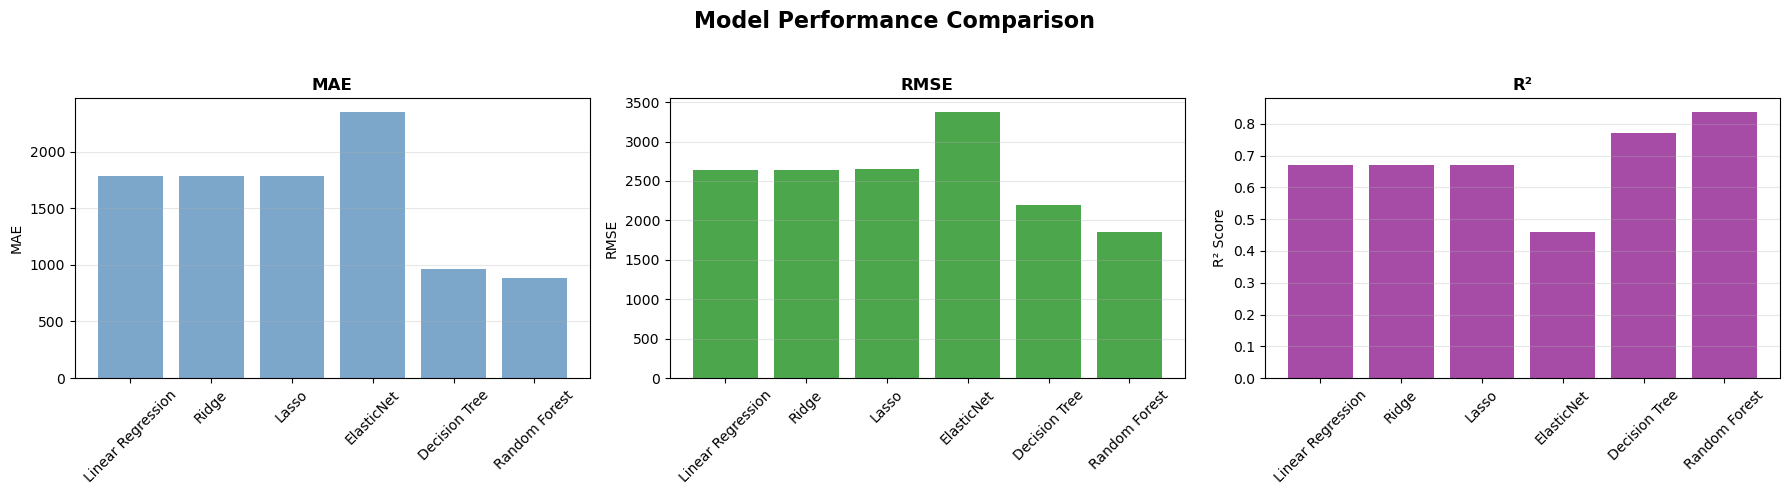

In [116]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# MAE
axes[0].bar(comparison_df['Model'], comparison_df['MAE'], color='steelblue', alpha=0.7)
axes[0].set_title('MAE', fontweight='bold')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# RMSE
axes[1].bar(comparison_df['Model'], comparison_df['RMSE'], color='green', alpha=0.7)
axes[1].set_title('RMSE', fontweight='bold')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# R²
axes[2].bar(comparison_df['Model'], comparison_df['R²'], color='purple', alpha=0.7)
axes[2].set_title('R²', fontweight='bold')
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Hyperparameter Tuning

In [117]:
# Define parameter grids for RandomizedSearchCV
param_grids = {
    'Linear Regression': {},  # No hyperparameters to tune
    'Ridge': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr']
    },
    'Lasso': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 5000, 10000]
    },
    'ElasticNet': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'max_iter': [1000, 5000, 10000]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
}

In [118]:
# Hyperparameter tuning with RandomizedSearchCV
tuned_results = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Tuning {model_name}...")
    print(f"{'='*60}")
    
    # Skip if no parameters to tune
    if not param_grids[model_name]:
        print(f"Skipping {model_name} - no hyperparameters to tune")
        tuned_results[model_name] = results[model_name]
        continue
    
    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[model_name],
        n_iter=20,  # Number of parameter settings sampled
        cv=5,  # 5-fold cross-validation
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the model
    random_search.fit(X_train_preprocessed, y_train)
    
    # Get best model
    best_model_tuned = random_search.best_estimator_
    
    # Make predictions
    y_pred_tuned = best_model_tuned.predict(X_test_preprocessed)
    
    # Calculate metrics
    mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    r2_tuned = r2_score(y_test, y_pred_tuned)
    
    # Store results
    tuned_results[model_name] = {
        'model': best_model_tuned,
        'mae': mae_tuned,
        'rmse': rmse_tuned,
        'r2': r2_tuned,
        'best_params': random_search.best_params_,
        'best_cv_score': random_search.best_score_
    }
    
    # Print results
    print(f"\n{model_name} - Tuned Results:")
    print(f"Best CV Score: {random_search.best_score_:.4f}")
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Test MAE: {mae_tuned:.2f}, RMSE: {rmse_tuned:.2f}, R²: {r2_tuned:.4f}")

print(f"\n\n{'='*60}")
print("Hyperparameter tuning completed!")
print(f"{'='*60}")


Tuning Linear Regression...
Skipping Linear Regression - no hyperparameters to tune

Tuning Ridge...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Ridge - Tuned Results:
Best CV Score: 0.6439
Best Parameters: {'solver': 'auto', 'alpha': 1}
Test MAE: 1784.41, RMSE: 2644.68, R²: 0.6695

Tuning Lasso...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Lasso - Tuned Results:
Best CV Score: 0.6438
Best Parameters: {'max_iter': 1000, 'alpha': 0.1}
Test MAE: 1783.90, RMSE: 2642.91, R²: 0.6700

Tuning ElasticNet...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

ElasticNet - Tuned Results:
Best CV Score: 0.6439
Best Parameters: {'max_iter': 5000, 'l1_ratio': 0.5, 'alpha': 0.001}
Test MAE: 1786.18, RMSE: 2651.55, R²: 0.6678

Tuning Decision Tree...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Decision Tree - Tuned Results:
Best CV Score: 0.7638
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 15}
Test 

In [119]:
# Create comparison dataframe for before and after tuning
comparison_before_after = pd.DataFrame({
    'Model': list(results.keys()),
    'Before Tuning (R²)': [results[m]['r2'] for m in results.keys()],
    'After Tuning (R²)': [tuned_results[m]['r2'] for m in tuned_results.keys()],
    'Improvement': [tuned_results[m]['r2'] - results[m]['r2'] for m in results.keys()]
})

comparison_before_after = comparison_before_after.sort_values('After Tuning (R²)', ascending=False)

print("\n" + "="*80)
print("BEFORE AND AFTER HYPERPARAMETER TUNING COMPARISON")
print("="*80)
print(comparison_before_after.to_string(index=False))
print("="*80)


BEFORE AND AFTER HYPERPARAMETER TUNING COMPARISON
            Model  Before Tuning (R²)  After Tuning (R²)  Improvement
    Random Forest            0.838541           0.838517    -0.000024
    Decision Tree            0.772837           0.782905     0.010068
Linear Regression            0.670025           0.670025     0.000000
            Lasso            0.669260           0.669959     0.000699
            Ridge            0.669518           0.669518     0.000000
       ElasticNet            0.460526           0.667799     0.207273


In [120]:
# Create detailed comparison dataframe for tuned models
tuned_comparison_df = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'MAE': [tuned_results[m]['mae'] for m in tuned_results.keys()],
    'RMSE': [tuned_results[m]['rmse'] for m in tuned_results.keys()],
    'R²': [tuned_results[m]['r2'] for m in tuned_results.keys()],
    'Best CV Score': [tuned_results[m].get('best_cv_score', 'N/A') for m in tuned_results.keys()]
})

tuned_comparison_df = tuned_comparison_df.sort_values('R²', ascending=False)

print("\n" + "="*100)
print("TUNED MODELS - DETAILED PERFORMANCE METRICS")
print("="*100)
print(tuned_comparison_df.to_string(index=False))
print("="*100)


TUNED MODELS - DETAILED PERFORMANCE METRICS
            Model         MAE        RMSE       R² Best CV Score
    Random Forest 1038.224704 1848.681262 0.838517      0.799776
    Decision Tree  999.165325 2143.498702 0.782905      0.763805
Linear Regression 1783.883081 2642.646383 0.670025           N/A
            Lasso 1783.901466 2642.908958 0.669959      0.643795
            Ridge 1784.410080 2644.676340 0.669518        0.6439
       ElasticNet 1786.183485 2651.545680 0.667799      0.643947


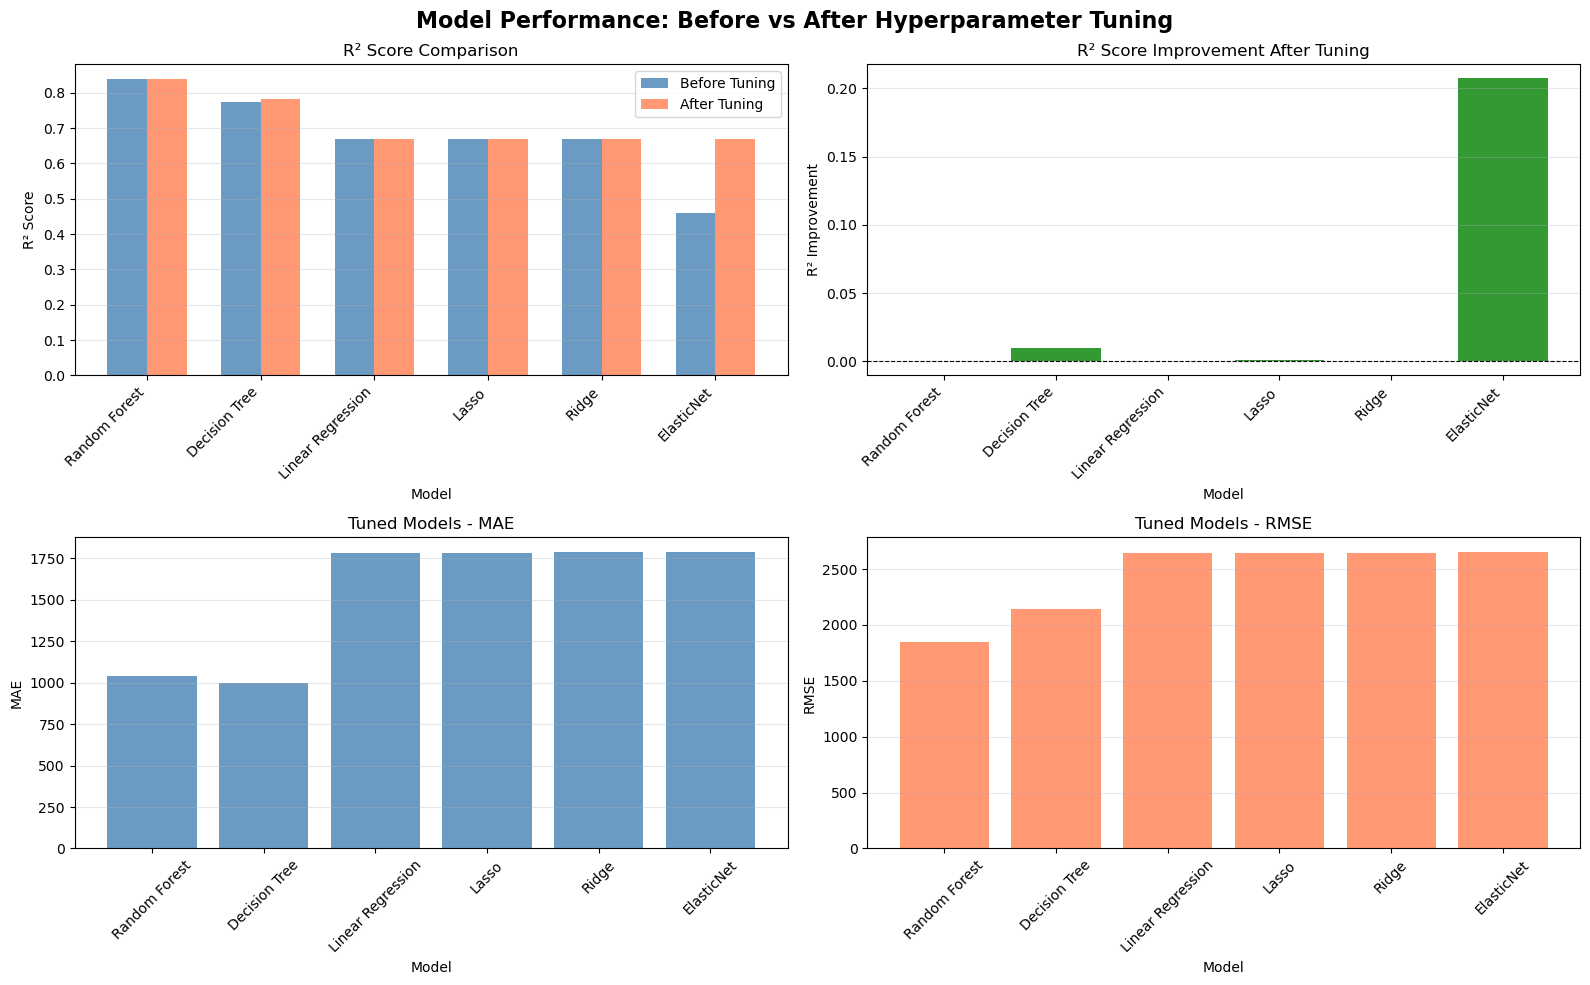

In [121]:
# Visualize before and after tuning comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Model Performance: Before vs After Hyperparameter Tuning', fontsize=16, fontweight='bold')

# R² Comparison (Before vs After)
x_pos = np.arange(len(comparison_before_after))
width = 0.35

axes[0, 0].bar(x_pos - width/2, comparison_before_after['Before Tuning (R²)'], width, label='Before Tuning', color='steelblue', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, comparison_before_after['After Tuning (R²)'], width, label='After Tuning', color='coral', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(comparison_before_after['Model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Improvement
colors_improvement = ['green' if x > 0 else 'red' for x in comparison_before_after['Improvement']]
axes[0, 1].bar(range(len(comparison_before_after)), comparison_before_after['Improvement'], color=colors_improvement, alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('R² Improvement')
axes[0, 1].set_title('R² Score Improvement After Tuning')
axes[0, 1].set_xticks(range(len(comparison_before_after)))
axes[0, 1].set_xticklabels(comparison_before_after['Model'], rotation=45, ha='right')
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0, 1].grid(axis='y', alpha=0.3)

# MAE Comparison (Tuned)
axes[1, 0].bar(tuned_comparison_df['Model'], tuned_comparison_df['MAE'], color='steelblue', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Tuned Models - MAE')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# RMSE Comparison (Tuned)
axes[1, 1].bar(tuned_comparison_df['Model'], tuned_comparison_df['RMSE'], color='coral', alpha=0.8)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('Tuned Models - RMSE')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

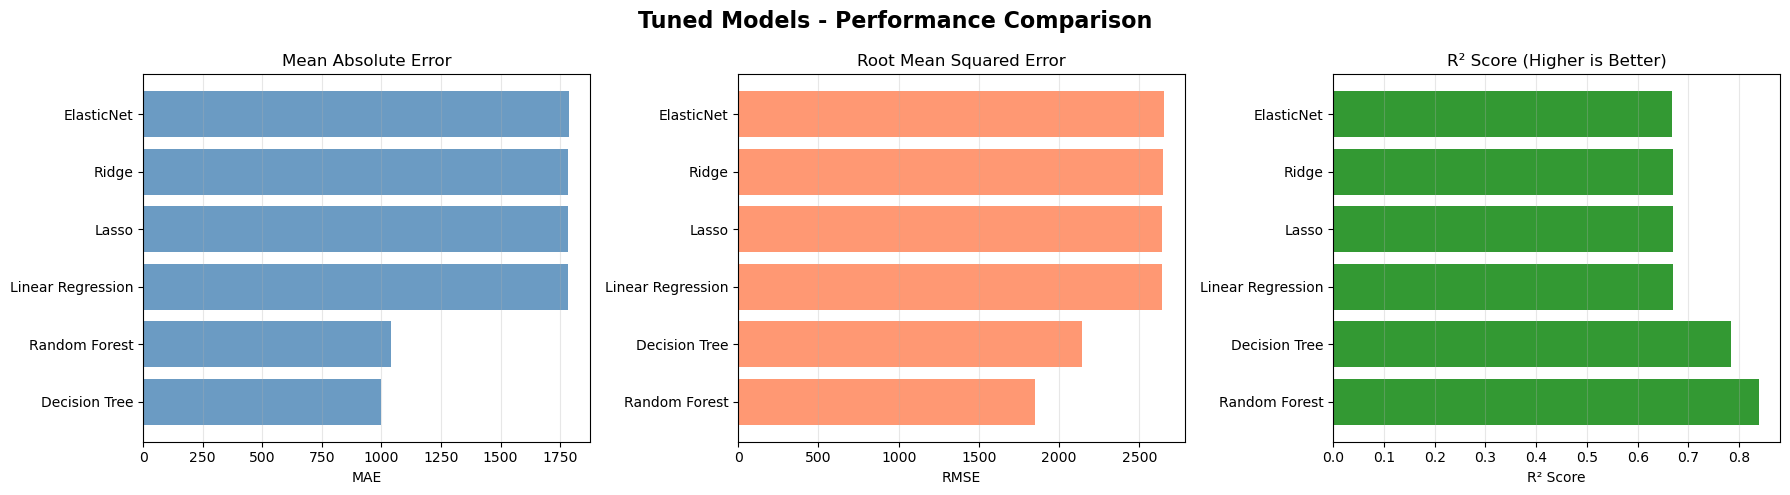

In [122]:
# Create comprehensive comparison - All metrics visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Tuned Models - Performance Comparison', fontsize=16, fontweight='bold')

# MAE
sorted_df = tuned_comparison_df.sort_values('MAE')
axes[0].barh(sorted_df['Model'], sorted_df['MAE'], color='steelblue', alpha=0.8)
axes[0].set_xlabel('MAE')
axes[0].set_title('Mean Absolute Error')
axes[0].grid(axis='x', alpha=0.3)

# RMSE
sorted_df_rmse = tuned_comparison_df.sort_values('RMSE')
axes[1].barh(sorted_df_rmse['Model'], sorted_df_rmse['RMSE'], color='coral', alpha=0.8)
axes[1].set_xlabel('RMSE')
axes[1].set_title('Root Mean Squared Error')
axes[1].grid(axis='x', alpha=0.3)

# R²
sorted_df_r2 = tuned_comparison_df.sort_values('R²', ascending=False)
axes[2].barh(sorted_df_r2['Model'], sorted_df_r2['R²'], color='green', alpha=0.8)
axes[2].set_xlabel('R² Score')
axes[2].set_title('R² Score (Higher is Better)')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [123]:
# Update best model with tuned version
best_tuned_model_name = tuned_comparison_df.iloc[0]['Model']
best_tuned_model_obj = tuned_results[best_tuned_model_name]['model']
best_tuned_r2 = tuned_comparison_df.iloc[0]['R²']

print(f"\n{'='*80}")
print("BEST TUNED MODEL")
print(f"{'='*80}")
print(f"Model Name: {best_tuned_model_name}")
print(f"R² Score: {best_tuned_r2:.4f}")
print(f"MAE: {tuned_comparison_df.iloc[0]['MAE']:.2f}")
print(f"RMSE: {tuned_comparison_df.iloc[0]['RMSE']:.2f}")

if 'best_params' in tuned_results[best_tuned_model_name]:
    print("\nBest Parameters:")
    for param, value in tuned_results[best_tuned_model_name]['best_params'].items():
        print(f"  {param}: {value}")

print(f"\n{'='*80}")


BEST TUNED MODEL
Model Name: Random Forest
R² Score: 0.8385
MAE: 1038.22
RMSE: 1848.68

Best Parameters:
  n_estimators: 50
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: log2
  max_depth: 30



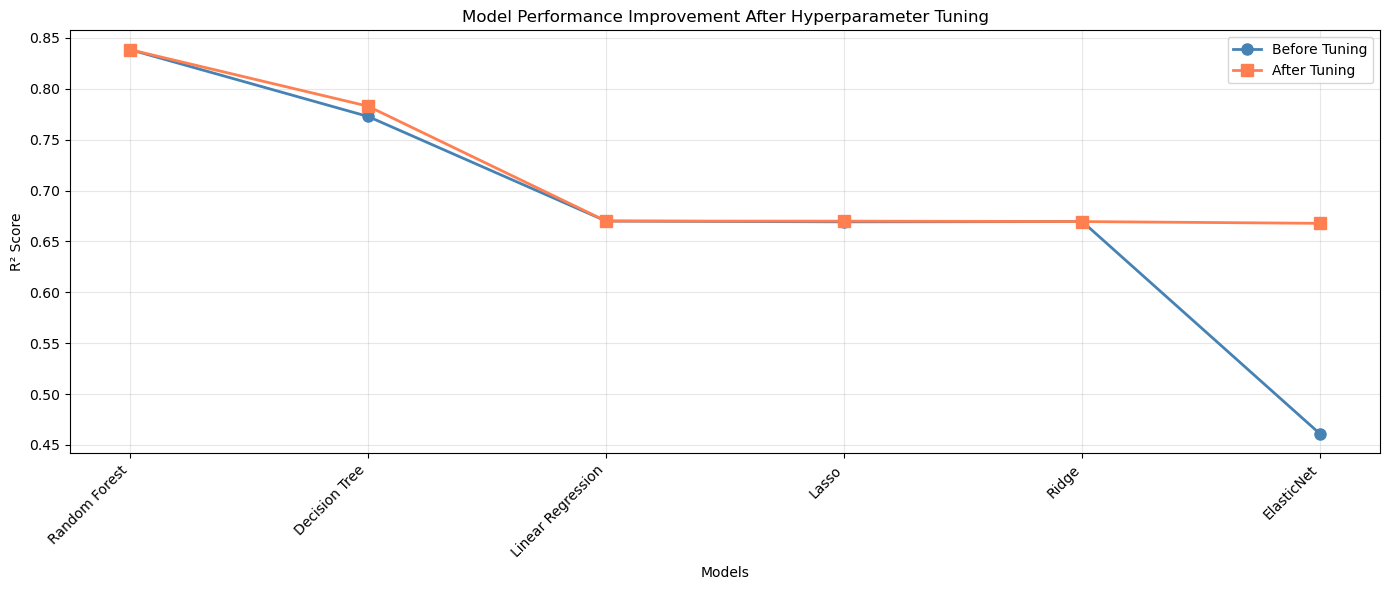

In [124]:
# Line plot comparing all models before and after
plt.figure(figsize=(14, 6))

models_list = comparison_before_after['Model'].values
before = comparison_before_after['Before Tuning (R²)'].values
after = comparison_before_after['After Tuning (R²)'].values

x = np.arange(len(models_list))
plt.plot(x, before, marker='o', linewidth=2, markersize=8, label='Before Tuning', color='steelblue')
plt.plot(x, after, marker='s', linewidth=2, markersize=8, label='After Tuning', color='coral')

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Improvement After Hyperparameter Tuning')
plt.xticks(x, models_list, rotation=45, ha='right')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

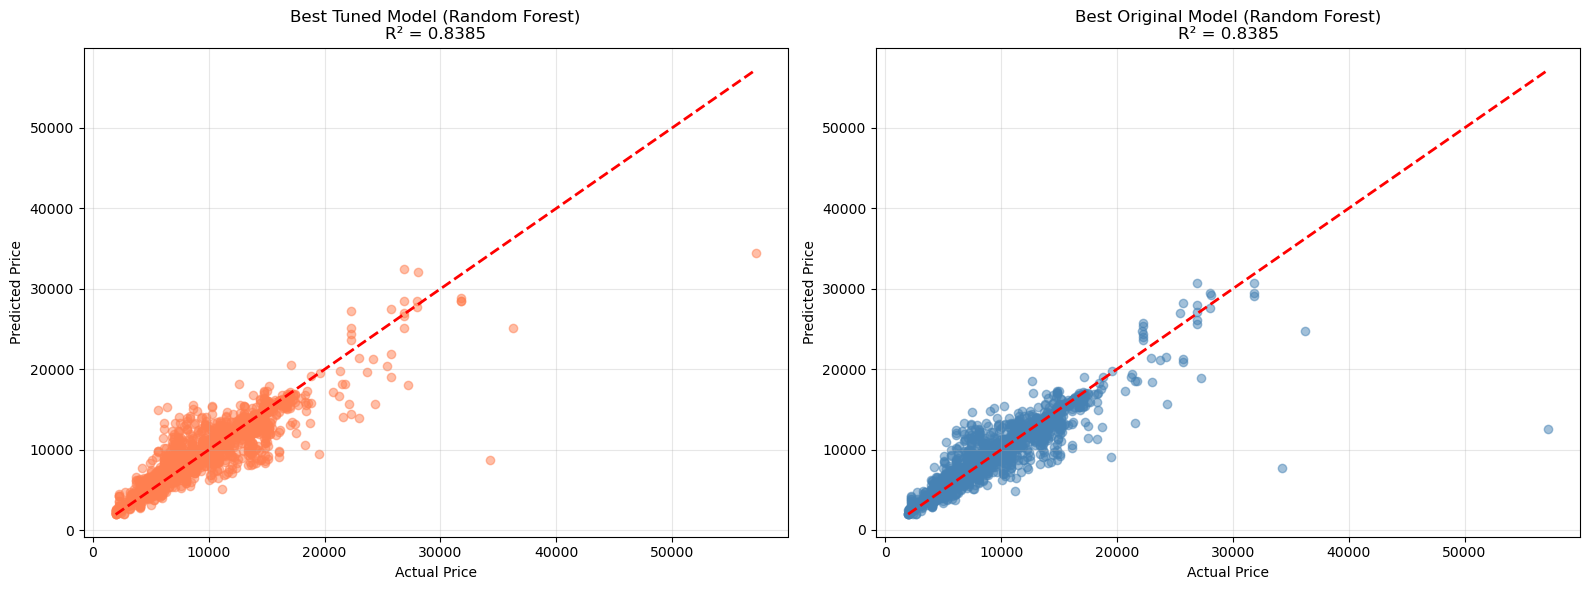

In [125]:
# Prediction comparison - Best original vs Best tuned
best_original_name = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
best_original_model = results[best_original_name]['model']

best_tuned_predictions = best_tuned_model_obj.predict(X_test_preprocessed)
best_original_predictions = best_original_model.predict(X_test_preprocessed)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted (Tuned Model)
axes[0].scatter(y_test, best_tuned_predictions, alpha=0.5, color='coral')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'Best Tuned Model ({best_tuned_model_name})\nR² = {best_tuned_r2:.4f}')
axes[0].grid(alpha=0.3)

# Actual vs Predicted (Original Best Model)
best_original_r2 = comparison_df.loc[comparison_df['Model'] == best_original_name, 'R²'].values[0]
axes[1].scatter(y_test, best_original_predictions, alpha=0.5, color='steelblue')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title(f'Best Original Model ({best_original_name})\nR² = {best_original_r2:.4f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Best Model Selection

In [126]:
# Get the best tuned model (after hyperparameter tuning)
best_model_name = tuned_comparison_df.iloc[0]['Model']
best_model_obj = tuned_results[best_model_name]['model']
best_model_r2 = tuned_comparison_df.iloc[0]['R²']
best_model_mae = tuned_comparison_df.iloc[0]['MAE']
best_model_rmse = tuned_comparison_df.iloc[0]['RMSE']

### Saving Best Model 

In [127]:
# Create models directory
os.makedirs('models/', exist_ok=True)

# Save the best tuned model
model_path = 'models/best_model.pkl'
joblib.dump(best_model_obj, model_path)

# Save the preprocessor (needed for new predictions)
preprocessor_path = 'models/preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_path)

# Save feature names
feature_names_path = 'models/feature_names.pkl'
joblib.dump(feature_names, feature_names_path)

# Save best tuned model hyperparameters
if 'best_params' in tuned_results[best_model_name]:
    best_params_path = 'models/best_params.pkl'
    joblib.dump(tuned_results[best_model_name]['best_params'], best_params_path)
    print("Best parameters saved!")

print(f"\n{'='*80}")
print("BEST MODEL SAVED SUCCESSFULLY")
print(f"{'='*80}")
print(f"\nModel Name: {best_model_name}")
print(f"R² Score: {best_model_r2:.4f}")
print(f"MAE: {best_model_mae:.2f}")
print(f"RMSE: {best_model_rmse:.2f}")

if 'best_params' in tuned_results[best_model_name]:
    print("\nBest Hyperparameters:")
    for param, value in tuned_results[best_model_name]['best_params'].items():
        print(f"  • {param}: {value}")

print(f"\n{'='*80}")
print("SAVED FILES:")
print(f"{'='*80}")
print(f"Model:              {model_path}")
print(f"Preprocessor:       {preprocessor_path}")
print(f"Feature Names:      {feature_names_path}")
if 'best_params' in tuned_results[best_model_name]:
    print(f"Best Parameters:    {best_params_path}")
print(f"\n{'='*80}")

Best parameters saved!

BEST MODEL SAVED SUCCESSFULLY

Model Name: Random Forest
R² Score: 0.8385
MAE: 1038.22
RMSE: 1848.68

Best Hyperparameters:
  • n_estimators: 50
  • min_samples_split: 5
  • min_samples_leaf: 1
  • max_features: log2
  • max_depth: 30

SAVED FILES:
Model:              models/best_model.pkl
Preprocessor:       models/preprocessor.pkl
Feature Names:      models/feature_names.pkl
Best Parameters:    models/best_params.pkl

